In [19]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, RampCurrentInjection
import act.data_processing as dp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import summary_features_error
import shutil

### Generate target data

In [87]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "Cell_A",
    path_to_hoc_file = "../../data/LAA/orig_cutoff_test/template.hoc",
    path_to_mod_files = "../../data/LAA/orig_cutoff_test/modfiles/",
    passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
    active_channels = ["gbar_na3", "gbar_nap", "gkdrbar_kdr", "gmbar_im", "gkabar_kap", "gcabar_cadyn"],
)

In [3]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

# Constant CI targets
for amp_idx, amp in enumerate([0, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "target_constant",
        sim_idx = amp_idx,
        h_celsius = 37,
        h_dt = 0.1,
        h_tstop = 1000,
        h_v_init = -40,
        CI = [ConstantCurrentInjection(amp = amp, dur = 700, delay = 100)]
        )

    simulator.submit_job(target_cell, sim_params)

# Ramp CI targets
for amp_idx, num_steps in enumerate([5, 10, 15]):
    sim_params = SimulationParameters(
        sim_name = "target_ramp",
        sim_idx = amp_idx,
        h_celsius = 37,
        h_dt = 0.1,
        h_tstop = 1000,
        h_v_init = -40,
        CI = [RampCurrentInjection(amp_incr = 0.01, num_steps = num_steps, dur = 300, delay = 100, final_step_add_time = 400)]
        )

    simulator.submit_job(target_cell, sim_params)

simulator.run_jobs(3)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


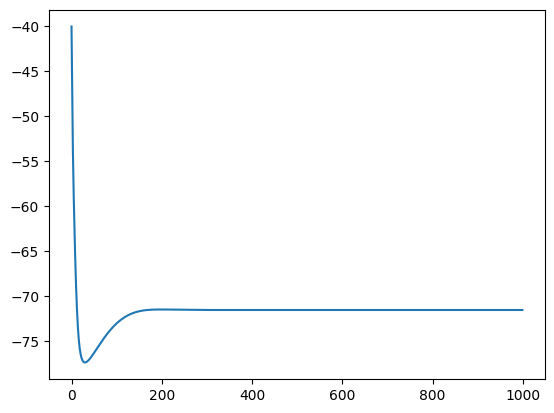

In [85]:
passive_trace = np.load("output/target_constant/out_0.npy")[:, 0]
plt.plot(passive_trace[::10])

In [6]:
dp.combine_data("output/target_constant")
dp.combine_data("output/target_ramp")

output/target_constant/combined_out.npy
output/target_ramp/combined_out.npy


In [20]:
# Compute the error with respective target summary features
summary_features_target = []
for sf_type in ["target_constant", "target_ramp"]:
    data = np.load(f"output/{sf_type}/combined_out.npy")
    V = data[:, ::10, 0].reshape((3, -1))
    I = data[:, ::10, 1].reshape((3, -1))
    summary_features_target.append(dp.get_summary_features(V, I, window = (100, 800) if sf_type == "target_constant" else (400, 800)))

summary_features_target = pd.concat(summary_features_target, axis = 0).reset_index(drop = True)

In [18]:
# LTO: NaP, KM

def modify_template(passive_th, lto_th, spiking_th, bursting_th):
    
    passive = [
        ("h.mod", 78, passive_th) # modfile, line
    ]
    lto = [
        ("nap.mod", 65, lto_th), 
        ("im.mod", 73, lto_th)
    ]
    spiking = [
        ("na3.mod", 96, spiking_th), 
        ("kdrca1.mod", 82, spiking_th)
    ]
    bursting = [
        ("kaprox.mod", 110, bursting_th), 
        ("cadyn.mod", 57, bursting_th)
    ]

    for entry in passive + lto + spiking + bursting:
        with open(f"../../data/LAA/orig_cutoff_test/modfiles/{entry[0]}", "r") as file:
            mod_file = file.readlines()

            sign = '>' if entry in passive else '<'
            mod_file[entry[1]] = "\t" + f"if (v {sign} {entry[2]}) " + "{\n"

        with open(f"../../data/LAA/orig_cutoff_test/modfiles/{entry[0]}", "w") as file:
            file.writelines(mod_file)

In [62]:
modify_template(-1, -1, -1, -1)

# Experiment

In [27]:
import os

def run_eval_single_simulation(current_injection, summary_features_target):

    print(os.getcwd())

    # Define the cell
    cell = ACTCellModel(
        cell_name = "Cell_A",
        path_to_hoc_file = "../../data/LAA/orig_cutoff_test/template.hoc",
        path_to_mod_files = "../../data/LAA/orig_cutoff_test/modfiles/",
        passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
        active_channels = ["gbar_na3", "gbar_nap", "gkdrbar_kdr", "gmbar_im", "gkabar_kap", "gcabar_cadyn"],
    )

    # Set simulations
    simulator = ACTSimulator(output_folder_name = "output")
    
    for inj_id, inj in enumerate(current_injection):
        sim_params = SimulationParameters(
            sim_name = "sim",
            sim_idx = inj_id,
            h_celsius = 37,
            h_dt = 0.1,
            h_tstop = 1000,
            h_v_init = -40,
            CI = [inj])

        simulator.submit_job(cell, sim_params)
        
    simulator.run_jobs(3)
    dp.combine_data("output/sim")

    # Get summary features
    data = np.load(f"output/sim/combined_out.npy")
    V = data[:, ::10, 0].reshape((6, -1))
    I = data[:, ::10, 1].reshape((6, -1))
    summary_features_constant = dp.get_summary_features(V[:3], I[:3], window = (100, 800))
    summary_features_ramp = dp.get_summary_features(V[3:], I[3:], window = (400, 800))
    summary_features = pd.concat([summary_features_constant, summary_features_ramp], axis = 0).reset_index(drop = True)

    # Clean
    shutil.rmtree("output/sim")

    return np.nanmean(summary_features_error(summary_features_target.to_numpy(), summary_features.to_numpy()))

In [28]:
# V-rest ~-70
all_errors = np.zeros(
    (
        len(np.arange(-80, -50, 10)), # passive
        len(np.arange(-80, -50, 10)), # LTO
        len(np.arange(-80, 10, 20)), # Spiking
        len(np.arange(-80, 10, 20)) # Bursting
    )
) * np.nan

In [29]:
all_errors.shape

(3, 3, 5, 5)

In [ ]:
for idx_1, passive_bound in enumerate(np.arange(-80, -50, 10)):
    for idx_2, lto_bound in enumerate(np.arange(-80, -50, 10)):
        for idx_3, spiking_bound in enumerate(np.arange(-80, 10, 20)):
            for idx_4, bursting_bound in enumerate(np.arange(-80, 10, 20)):
                # Set the bounds
                modify_template(passive_th = passive_bound, lto_th = lto_bound, spiking_th = spiking_bound, bursting_th = bursting_bound)
                
                # Run a simulation with constant current injection
                error = run_eval_single_simulation(
                    [
                        ConstantCurrentInjection(amp = 0, dur = 700, delay = 100),
                        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100),
                        ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100),
                        RampCurrentInjection(amp_incr = 0.01, num_steps = 5, dur = 300, delay = 100, final_step_add_time = 400),
                        RampCurrentInjection(amp_incr = 0.01, num_steps = 10, dur = 300, delay = 100, final_step_add_time = 400),
                        RampCurrentInjection(amp_incr = 0.01, num_steps = 15, dur = 300, delay = 100, final_step_add_time = 400)
                    ],
                    summary_features_target
                )
            
                all_errors[idx_1, idx_2, idx_3, idx_4] = error


In [36]:
np.unravel_index(np.argmin(all_errors), all_errors.shape)

(0, 0, 1, 3)

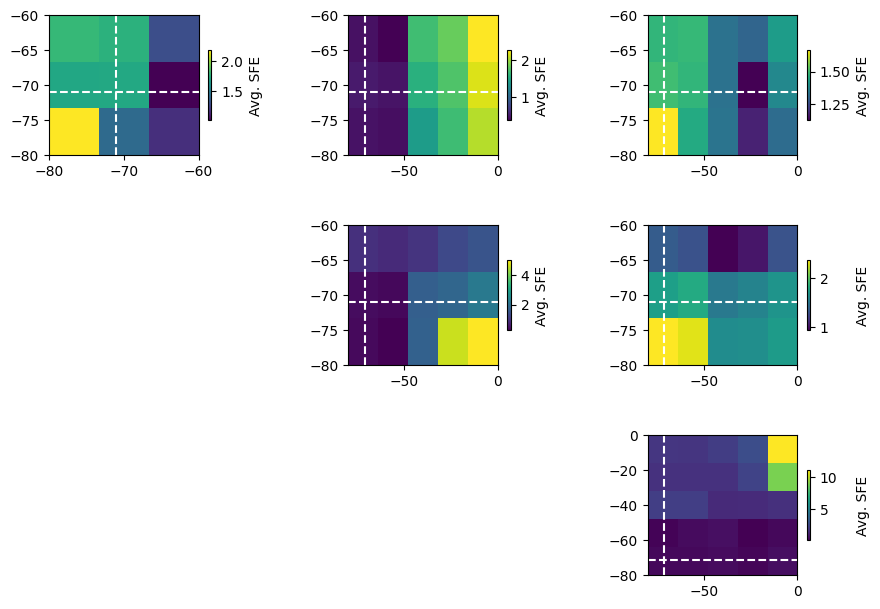

In [121]:
fig, ax = plt.subplots(4, 4, figsize = (14, 10))

ranges = {
    "Passive": np.arange(-80, -50, 10),
    "LTO": np.arange(-80, -50, 10),
    "Spiking": np.arange(-80, 10, 20),
    "Bursting": np.arange(-80, 10, 20)
}

cbars = []
for row_idx, module_row in enumerate(["Passive", "LTO", "Spiking", "Bursting"]):
    for col_idx, module_col in enumerate(["Passive", "LTO", "Spiking", "Bursting"]):

        ca = ax[row_idx, col_idx]

        drop_axes = np.arange(4)[(np.arange(4) != row_idx) & (np.arange(4) != col_idx)]
        matrix = np.nanmedian(all_errors, axis = tuple(drop_axes))

        if row_idx < col_idx:
            im = ca.imshow(
                matrix, 
                origin = 'lower', 
                extent = [ranges[module_col][0], ranges[module_col][-1], ranges[module_row][0], ranges[module_row][-1]],
                aspect = 'auto'
                )

            # ca.set_ylabel(module_row)
            # ca.set_xlabel(module_col)

            # ca.set_xticks(np.arange(len(ranges[module_col])))
            # ca.set_yticks(np.arange(len(ranges[module_row])))

            # ca.set_xticklabels(ranges[module_col])
            # ca.set_yticklabels(ranges[module_row])

            cbar = fig.colorbar(im, shrink = 0.5)
            cbar.ax.set_ylabel("Avg. SFE")
            if col_idx == 3:
                cbars.append(cbar.ax)

            # eleak_pos_x = np.arange(len(ranges[module_col]))[np.argmin(np.abs(ranges[module_col] - -70))]
            # eleak_pos_y = np.arange(len(ranges[module_row]))[np.argmin(np.abs(ranges[module_row] - -70))]
            ca.axhline(-71, color = "white", ls = '--')
            ca.axvline(-71, color = "white", ls = '--')
        else:
            fig.delaxes(ca)


plt.subplots_adjust(wspace = 0.6, hspace = 0.5)
fig.align_ylabels(cbars)

In [122]:
fig.savefig("LAA-segregation_sweeps2.png", bbox_inches = "tight", dpi = 500, format = "png")

In [76]:
ranges[module_col] == -70

array([False, False, False, False, False])

In [55]:
matrix.shape

(5,)

In [90]:
np.save("all_errors.npy", all_errors, allow_pickle = True)